In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from growth.sweep.sweep import Sweep
from clones.validation.sweep import SweepBenchmark
%matplotlib inline

In [2]:
ls ../synthetic/

ls: ../synthetic/: No such file or directory


# load sweep results

In [6]:
sweep_path = '../../synthetic/Sweep_181201_191516_katz/'
sweep = Sweep.load(sweep_path)
sweep

1 x 16 sweep, 4 recombination generations

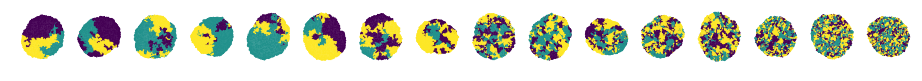

In [4]:
# plot single replicate for each batch
fig = sweep.plot_culture_grid(replicate_id=0, s=2)

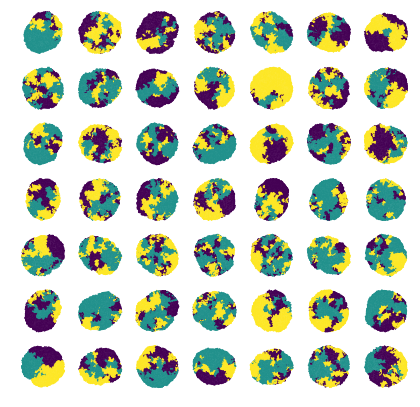

In [5]:
# plot all replicates for a single batch
fig = sweep.batches[0, 4].plot_culture_grid()

# load benchmarking results

In [4]:
benchmark = SweepBenchmark.load(sweep_path)

Results not compiled. Compile now?y


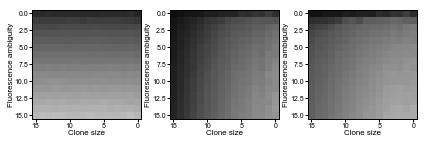

In [5]:
fig = benchmark.results.plot_absolute_error(log=True)

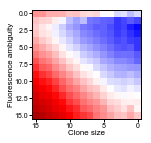

In [7]:
fig = benchmark.results.plot_relative_error(method='katz', reference_method='simple')

In [77]:
batch_id, scale_id = 0, 0
batch_benchmark = benchmark.load_benchmark(batch_id, scale_id)

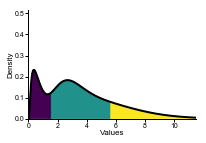

In [78]:
batch_benchmark.classifier.plot_pdf()

In [79]:
classifier = batch_benchmark.classifier

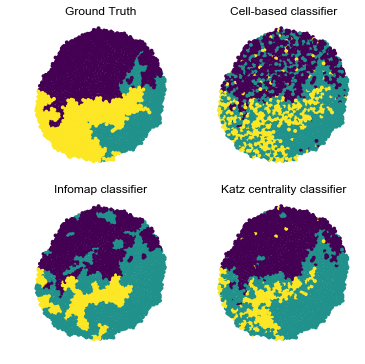

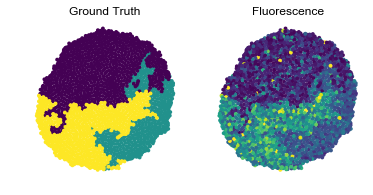

In [81]:
batch_benchmark.katz_kwargs['alpha'] = 0.9
simulation_benchmark = batch_benchmark.benchmark_simulation(0)
simulation_benchmark.show_classifiers(s=15)
simulation_benchmark.show_measurements(s=15)

In [12]:
print('Simple: {:0.3f}'.format(simulation_benchmark.scores['simple'].MAE))
print('Community: {:0.3f}'.format(simulation_benchmark.scores['community'].MAE))
print('Katz: {:0.3f}'.format(simulation_benchmark.scores['katz'].MAE))

Simple: 0.039
Community: 0.019
Katz: 0.016


NameError: name 'ErrorColorbar' is not defined

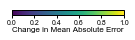

In [19]:
from growth.visualization.colorbars import ColorBar, ErrorColorBar
cbar = ColorBar(label='Change in Mean Absolute Error')
ebar = ErrorColorbar(vlim=(-8, 8), label='Fold-change in Mean Absolute Error')

In [39]:
classifier = batch_benchmark.classifier

In [40]:
simulation_benchmark = batch_benchmark.benchmark_simulation(0)

In [74]:
katz = KatzLabeler(simulation_benchmark.annotator.graph, classifier, alpha=0.92, label='NEW_KATZ')
katz(simulation_benchmark.df)

In [75]:
(simulation_benchmark.df.katz_genotype != simulation_benchmark.df.NEW_KATZ).sum()

22

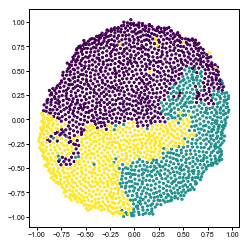

In [76]:
fig, ax = plt.subplots()
xy = simulation_benchmark.df[['centroid_x', 'centroid_y']].values
c = simulation_benchmark.df.NEW_KATZ.values
ax.scatter(*xy.T, c=c, s=5)
ax.set_aspect(1)

In [61]:
import networkx as nx
from clones.annotation.community import InfomapLabeler


class KatzLabeler(InfomapLabeler):
    """
    Object for assigning genotypes to cells based on their local community by using the Katz centrality of the posterior distributions fit to cell fluorescence levels.

    Attributes:

        graph (Graph) - graph connecting adjacent cells

        cell_classifier (CellClassifier) - callable object

        labeler (KatzClassifier) - callable object

    Inherited attributes:

        label (str) - name of label field to be added

        attribute (str) - existing cell attribute used to determine labels

    """

    def __init__(self, graph, cell_classifier,
                 label='katz_genotype',
                 **kwargs):
        """
        Instantiate community-based genotype annotation object.

        Args:

            graph (Graph) - graph connecting adjacent cells

            cell_classifier (CellClassifier) - callable object

            label (str) - name of <genotype> attribute to be added

            kwargs: keyword arguments for KatzClassifier, e.g. alpha

        """

        # store label and attribute field names
        self.label = label

        # run community detection and store graph
        self.graph = graph

        # store cell classifier
        self.cell_classifier = cell_classifier

        # build genotype labeler based on community classifier
        self.labeler = self.build_classifier(**kwargs)

    def assign_labels(self, data):
        """
        Assign labels by adding <label> field to cell measurement data.

        Args:

            data (pd.DataFrame) - cells measurement data

        """
        data[self.label] = self.labeler(data.index.values)

    def build_classifier(self, **kwargs):
        """
        Build Katz classifier.

        Args:

            kwargs: keyword arguments for Katz classifier, e.g. alpha

        Returns:

            classifier (func) - maps measurement index to cell genotype

        """
        return self._build_classifier(self.graph, self.cell_classifier, **kwargs)

    @staticmethod
    def _build_classifier(graph, cell_classifier, alpha=0.9):
        """
        Construct classifier baed on the maximum Katz centrality of posterior distributions applied to undirected edges weighted by node similarity.

        Args:

            graph (Graph) - graph connecting adjacent cells

            cell_classifier (BayesianClassifier) - labels individual cells

            alpha (float) - attenuation factor

        Returns:

            genotypes_dict (dict) - maps measurement index to genotype

        """

        # build undirected graph weighted by node similarity
        G = graph.get_networkx()

        # evaluate posterior genotype distribution for each node
        posterior = cell_classifier.evaluate_posterior(graph.df.loc[list(G.nodes)])

        # compile normalized adjacency matrix
        adjacency = nx.to_numpy_array(G)
        adjacency /= adjacency.sum(axis=0)

        # evaluate centrality
        n = np.array(adjacency).shape[0]
        centrality = np.linalg.solve(np.eye(n, n)-(alpha*adjacency), (1-alpha)*posterior)
        
        # build classifier that maps model distributions to genotypes.
        #get_label = np.vectorize(cell_classifier.component_to_label.get)
        node_labels = centrality.argmax(axis=1)

        # return genotype mapping
        index_to_genotype = dict(zip(list(G.nodes), node_labels))

        return np.vectorize(index_to_genotype.get)